# Name: Hithesh Shanmugam
# Subject code: CSC 578
# Final Project

# Predicting the future traffic volume

Introduction: The dataset is an open dataset available at Kaggle.
The information in the data was regarding the traffic volume and weather conditions on a highway between Minneapolis and St. Paul, Minnesota.

Goal: Apply deep learning to perform time series forecasting.

Approach: Using different Recurrent Neural Netwrok architectures predicting the traffic volume 2 hrs per time steps into the future.

### Importing Libraries 

In [3]:
import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading a csv file

In [5]:
#reading the csv file using pandas
traffic_data=pd.read_csv('/content/drive/MyDrive/Metro_Interstate_reduced.csv')

# Exploratory Data Analysis 

## (A) Understanding and Preprocessing Data

In [6]:
#Inspection of the dataset 

print('The Shape of the dataset:', traffic_data.shape, '\n')# printing the shape of the data
traffic_data.head()# displaying the first five of the dataset using in-buit function head

The Shape of the dataset: (40575, 9) 



,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [7]:
traffic_data.tail()# displaying the last five of the dataset using in-buit function tail

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
40570,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
40571,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
40572,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
40573,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
40574,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


As we can see from above the number of different types of variables can be categorised as,

Numerical variables-5: (temp, rain_1h, snow_1h, clouds_all, and traffic_volume)

Categorical variables-3: (holiday, weather_main, and weather_description)

Ordinal variable-1: (date_time)

Target variable: traffic_volume

## (B) Data Visualisation

In [8]:
import matplotlib.pyplot as plt# importing this library for visualisation

Histogram representation of the numerical variables
Note: Now here only five variables are shown because they are the only numerical variables

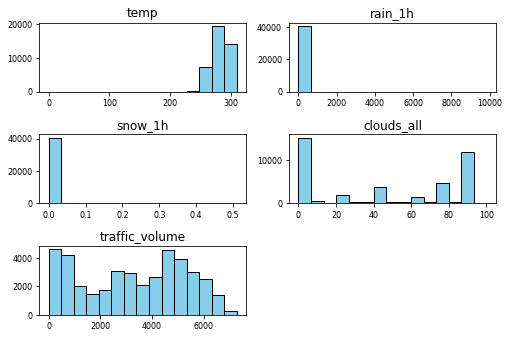

In [9]:
#histogram representation of the data
traffic_data.hist(bins=15, color='skyblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)#skyblue was more precise than the other colors   
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

In [10]:
import seaborn as sns#importing seaborn for pairplot

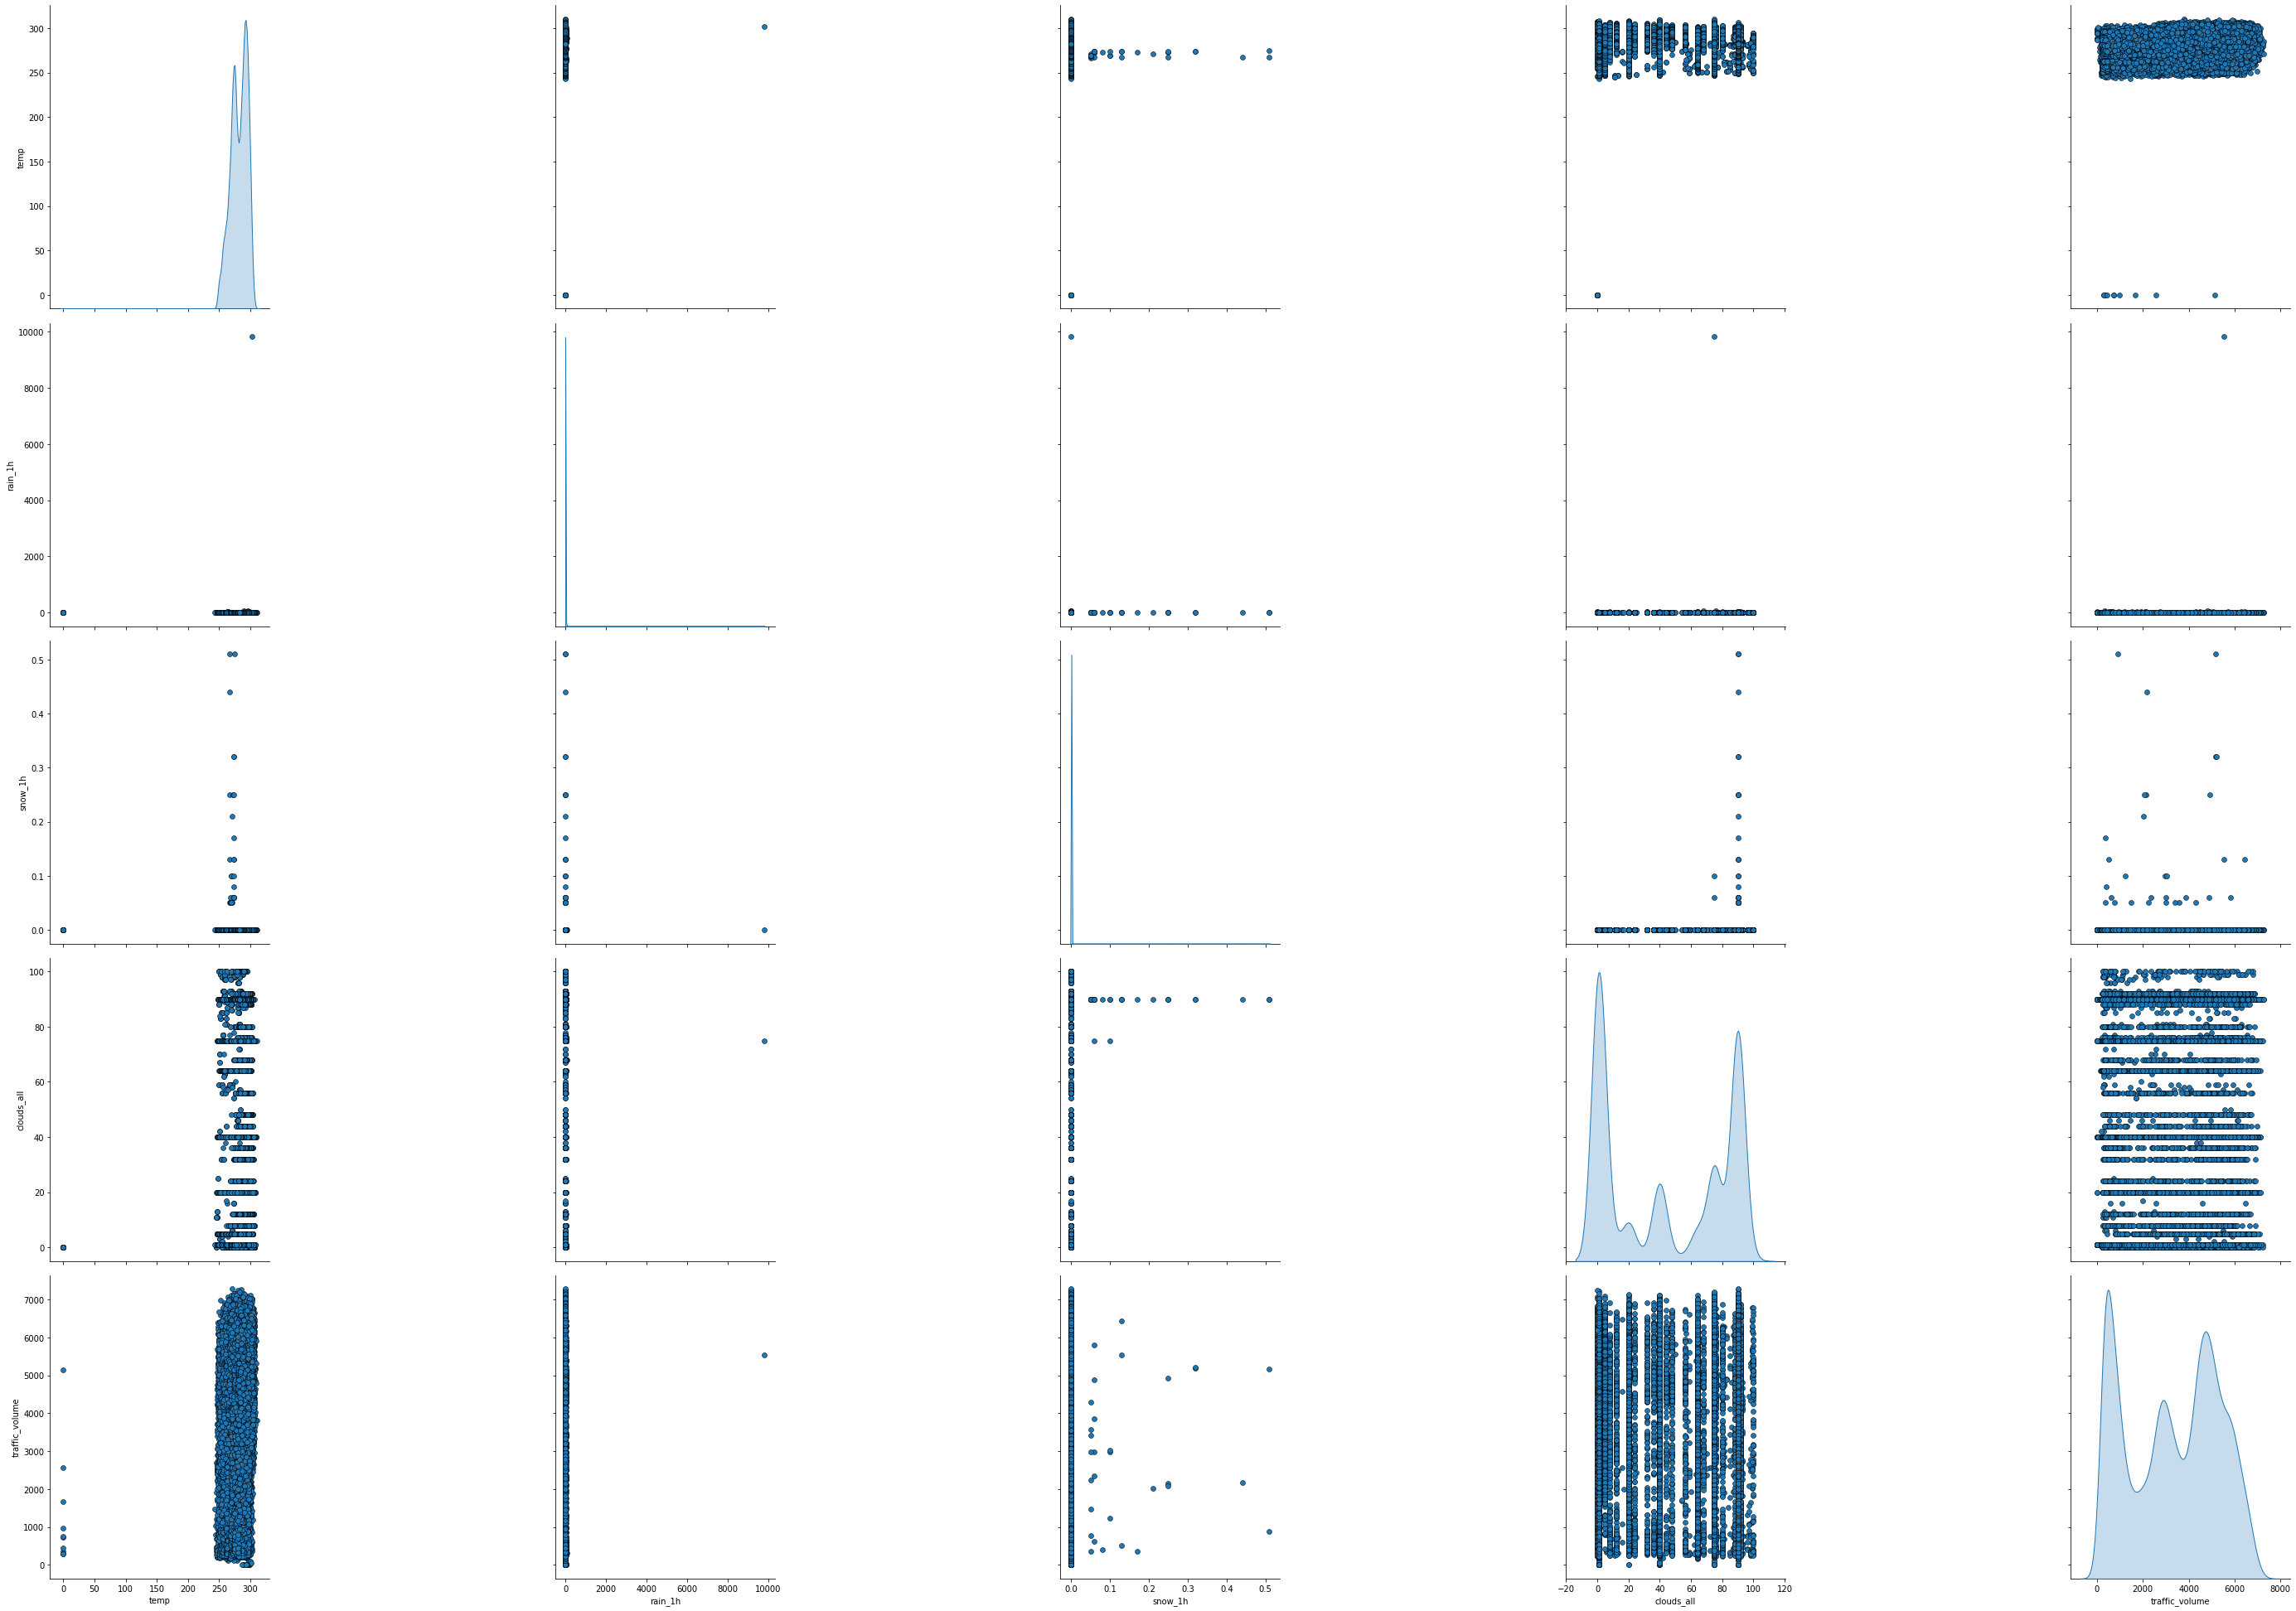

In [11]:
correlated_plot = sns.pairplot(traffic_data, size=2.8, aspect=2.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))#passing the dataset in the pairplot

fig = correlated_plot.fig #representing the correlation
fig.subplots_adjust(top=1.93, wspace=1.3)
plt.show()

In the histogram representation of the data we can see some of the data has skewness,kurtosis.

To view how correlated the variables are by using the pairplot in-built function 


Target variable distribution:

This is just to show the distribution of the traffic_volume data that is to represent the distribution of the target variable in our dataset

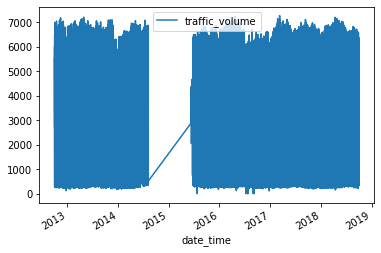

In [12]:
data_viz = traffic_data.copy()#copying for later use
date_time = pd.to_datetime(data_viz.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

plot_cols = ['traffic_volume']#target variable
plot_features = traffic_data[plot_cols]

plot_features.index = date_time
_ = plot_features.plot(subplots=True)#plotting the target variable

### Checking the types of data 

In [13]:
traffic_data.info()#checking the datatypes by using the in-built function info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              40575 non-null  object 
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  object 
 6   weather_description  40575 non-null  object 
 7   date_time            40575 non-null  object 
 8   traffic_volume       40575 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ MB


After checking the data type I came to a conclusion to convert the date_time variable is not in a correct format

### Converting date_time variable to correct format

In [14]:
traffic_data['date_time'] = pd.to_datetime(traffic_data['date_time'])# using pandas converting the date_time variable

From using the head and tail functions previously I could see the date_time variable has month,day and hour so I am trying to split the date_time variable

### Separating the date_time variable 

In [15]:
traffic_data['month'] = traffic_data['date_time'].dt.month#extracting month from the date_time
traffic_data['day_of_week'] = traffic_data['date_time'].dt.dayofweek#extracting day from the date_time
traffic_data['hour'] = traffic_data['date_time'].dt.hour#extracting hour from the date_time

To make sure the separation was done check the info again

In [16]:
traffic_data.info()#checking again with in-built function info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              40575 non-null  object        
 1   temp                 40575 non-null  float64       
 2   rain_1h              40575 non-null  float64       
 3   snow_1h              40575 non-null  float64       
 4   clouds_all           40575 non-null  int64         
 5   weather_main         40575 non-null  object        
 6   weather_description  40575 non-null  object        
 7   date_time            40575 non-null  datetime64[ns]
 8   traffic_volume       40575 non-null  int64         
 9   month                40575 non-null  int64         
 10  day_of_week          40575 non-null  int64         
 11  hour                 40575 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 3.7+ MB


Data Statistics:
To view the descriptive statistics for the numerical fields, view the mean,std,min,max etc.

In [17]:
traffic_data.describe()#describing the data using the in-built function describe

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,day_of_week,hour
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.316763,0.318632,0.000117,44.199162,3290.650474,6.489045,3.006778,11.514750
std,13.816618,48.812640,0.005676,38.683447,1984.772909,3.373618,1.998947,6.949889
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,271.840000,0.000000,0.000000,1.000000,1248.500000,4.000000,1.000000,5.000000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000,7.000000,3.000000,12.000000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000,9.000000,5.000000,18.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000,12.000000,6.000000,23.000000


Dropping categorical variables:

There are total of three categorical variables in the dataset and removing one of them and getting dummies for "holiday" and "weather_main" because I think they have some important data . And also in the variable "holiday" there are only few holidays listed in the data so I converted it to holiday abd workday 

So I am dropping these variables: "month", "day_of_week", "weather_description" and "date_time"

In [18]:
traffic_data = traffic_data.drop(['month','day_of_week'],axis = 1)#dropping the converted date time variables and keeping only the hour

In [19]:
traffic_data.head()#first five of the dataset

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13


In [20]:
#from TF tutorial
timestamp_s = date_time.map(pd.Timestamp.timestamp)#for getting the day and year

In [21]:
#from TF tutorial
day = 24*60*60#setting the day
year = (365.2425)*day#setting the year

traffic_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))#introducing day sin in the dataset
traffic_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))#introducing day cos in the dataset
traffic_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))#introducing year sin in the dataset
traffic_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))#introducing year cos in the dataset

In [22]:
replacement={'Columbus Day':'holiday', 'Veterans Day':'holiday' , 'Thanksgiving Day':'holiday' , 'Christmas Day':'holiday', 'New Years Day':'holiday',  'Washingtons Birthday':'holiday', 'Memorial Day':'holiday', 'Independence Day':'holiday', 
'State Fair':'holiday' , 'Labor Day':'holiday' , 'Columbus Day':'holiday','None':'workday'  }#assigning the variables to holiday and workday to get dummies
traffic_data=traffic_data.replace(replacement)#replacing the holidays in the dataset

Getting dummies for two of the categorical variables because I think they have some important data

In [23]:
traffic_data=pd.get_dummies(traffic_data,columns=['weather_main','holiday'])#getting dummies for weather_main and holiday

In [24]:
traffic_data = traffic_data.drop(['weather_description'], axis = 1)#dropping the categorical variables
traffic_data = traffic_data.drop(['date_time'],axis=1)#dropping categorical variables

## (C) Data Splitting

To use the RNN model we need to split the data set into three categories as train validation and test sets.

In [25]:
#from TF tutorial
column_indices = {name: i for i, name in enumerate(traffic_data.columns)}#dictionary where the columns of the dataset is stored

n = len(traffic_data)#length of the dataset

train_traffic_data = traffic_data[0:30574]#70% of the data is used as training
val_traffic_data = traffic_data[30575:35574]#30% of the data is used as validation 
test_traffic_data = traffic_data[35575:]#the last 5000 rows of the dataframe is used as testing

num_features = traffic_data.shape[1]

#### Training data

In [26]:
train_traffic_data.head()#The first five of the training data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
0,288.28,0.0,0.0,40,5545,9,7.071068e-01,-0.707107,-0.999766,0.021642,...,0,0,0,0,0,0,0,0,0,1
1,289.36,0.0,0.0,75,4516,10,5.000000e-01,-0.866025,-0.999750,0.022358,...,0,0,0,0,0,0,0,0,0,1
2,289.58,0.0,0.0,90,4767,11,2.588190e-01,-0.965926,-0.999734,0.023075,...,0,0,0,0,0,0,0,0,0,1
3,290.13,0.0,0.0,90,5026,12,1.143105e-11,-1.000000,-0.999717,0.023791,...,0,0,0,0,0,0,0,0,0,1
4,291.14,0.0,0.0,75,4918,13,-2.588190e-01,-0.965926,-0.999700,0.024508,...,0,0,0,0,0,0,0,0,0,1


In [27]:
train_traffic_data.tail()#The last five of the training data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
30569,300.28,0.0,0.0,40,5408,18,-1.000000,-1.193416e-11,-0.604456,-0.796639,...,0,0,0,0,0,0,0,0,0,1
30570,299.49,0.0,0.0,40,3677,19,-0.965926,2.588190e-01,-0.605026,-0.796205,...,0,0,0,0,0,0,0,0,0,1
30571,298.58,0.0,0.0,40,3106,20,-0.866025,5.000000e-01,-0.605597,-0.795772,...,0,0,0,0,0,0,0,0,0,1
30572,296.15,0.0,0.0,75,3548,21,-0.707107,7.071068e-01,-0.606167,-0.795337,...,0,0,0,0,0,0,0,0,0,1
30573,293.84,0.0,0.0,75,2007,22,-0.500000,8.660254e-01,-0.606737,-0.794903,...,0,0,0,0,0,0,0,0,0,1


Data Statistics of the training data

In [28]:
train_traffic_data.describe()#The statistics of the training data 

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
count,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000,30574.00000,3.057400e+04,3.057400e+04,30574.000000,30574.000000,...,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000,30574.000000
mean,281.049675,0.408836,0.000156,44.923824,3273.248316,11.51341,-1.753715e-03,7.370474e-03,0.047603,-0.037369,...,0.018382,0.072480,0.117682,0.000425,0.051776,0.000033,0.008798,0.000065,0.001243,0.998692
std,13.943906,56.231857,0.006539,38.605765,1984.162221,6.95965,7.055837e-01,7.086092e-01,0.685220,0.725840,...,0.134329,0.259285,0.322236,0.020616,0.221578,0.005719,0.093387,0.008088,0.035233,0.036147
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.880000,0.000000,0.000000,1.000000,1229.250000,5.00000,-7.071068e-01,-7.071068e-01,-0.584161,-0.791636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,282.300000,0.000000,0.000000,40.000000,3389.000000,12.00000,-3.552769e-13,8.016706e-13,0.043549,-0.060921,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,291.940000,0.000000,0.000000,90.000000,4938.000000,18.00000,7.071068e-01,7.071068e-01,0.724743,0.705797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,308.240000,9831.300000,0.510000,100.000000,7280.000000,23.00000,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Validation data

In [29]:
val_traffic_data.head()#The first five of the validation data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
30575,291.69,0.0,0.0,1,676,0,5.440763e-14,1.000000,-0.607876,-0.794032,...,0,0,0,0,0,0,0,0,0,1
30576,291.09,0.0,0.0,1,395,1,2.588190e-01,0.965926,-0.608445,-0.793596,...,0,0,0,0,0,0,0,0,0,1
30577,290.37,0.0,0.0,1,306,2,5.000000e-01,0.866025,-0.609014,-0.793160,...,0,0,0,0,0,0,0,0,0,1
30578,290.08,0.0,0.0,40,381,3,7.071068e-01,0.707107,-0.609582,-0.792723,...,0,0,0,0,0,0,0,0,0,1
30579,289.86,0.0,0.0,1,949,4,8.660254e-01,0.500000,-0.610150,-0.792286,...,0,0,0,0,0,0,0,0,0,1


In [30]:
val_traffic_data.tail()#The last five of the validation data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
35569,272.09,0.0,0.0,90,1953,17,-0.965926,-2.588190e-01,0.892182,0.451676,...,0,0,0,0,1,0,0,0,0,1
35570,271.93,0.0,0.0,90,1389,18,-1.000000,-1.206420e-12,0.892506,0.451036,...,0,0,0,0,1,0,0,0,0,1
35571,271.65,0.0,0.0,90,1117,19,-0.965926,2.588190e-01,0.892829,0.450397,...,0,0,0,0,1,0,0,0,0,1
35572,271.28,0.0,0.0,90,844,20,-0.866025,5.000000e-01,0.893151,0.449757,...,0,0,0,0,1,0,0,0,0,1
35573,271.15,0.0,0.0,90,753,21,-0.707107,7.071068e-01,0.893473,0.449116,...,0,0,0,0,1,0,0,0,0,1


Data Statistics of the validation data

In [31]:
val_traffic_data.describe()#The statistics of the validation data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
count,4999.000000,4999.0,4999.0,4999.000000,4999.000000,4999.000000,4.999000e+03,4.999000e+03,4999.000000,4999.000000,...,4999.000000,4999.000000,4999.000000,4999.0,4999.00000,4999.0,4999.000000,4999.000000,4999.000000,4999.000000
mean,275.813688,0.0,0.0,44.650730,3320.095019,11.505701,-3.136924e-04,-1.012638e-03,-0.345236,0.417602,...,0.022805,0.097419,0.066013,0.0,0.10122,0.0,0.009202,0.000200,0.001600,0.998200
std,13.064682,0.0,0.0,39.374842,1984.883927,6.918342,7.076181e-01,7.067358e-01,0.626284,0.560652,...,0.149295,0.296558,0.248330,0.0,0.30165,0.0,0.095493,0.014144,0.039976,0.042397
min,246.150000,0.0,0.0,0.000000,186.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000,-0.794032,...,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000
25%,266.595000,0.0,0.0,1.000000,1306.000000,6.000000,-7.071068e-01,-7.071068e-01,-0.900698,-0.018209,...,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,1.000000
50%,274.750000,0.0,0.0,40.000000,3479.000000,12.000000,-5.540344e-14,-5.490553e-14,-0.622461,0.622716,...,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,1.000000
75%,287.085000,0.0,0.0,90.000000,4978.000000,18.000000,7.071068e-01,7.071068e-01,0.206471,0.900542,...,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,1.000000
max,306.580000,0.0,0.0,92.000000,7117.000000,23.000000,1.000000e+00,1.000000e+00,0.893473,1.000000,...,1.000000,1.000000,1.000000,0.0,1.00000,0.0,1.000000,1.000000,1.000000,1.000000


#### Testing data 

In [32]:
test_traffic_data.head()#The first five of the test data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
35575,271.36,0.0,0.0,90,599,23,-2.588190e-01,0.965926,0.894116,0.447835,...,0,0,0,0,1,0,0,0,0,1
35576,271.43,0.0,0.0,90,308,0,-3.769765e-12,1.000000,0.894437,0.447194,...,0,0,0,0,1,0,0,0,0,1
35577,271.43,0.0,0.0,90,242,1,2.588190e-01,0.965926,0.894757,0.446553,...,0,0,0,0,1,0,0,0,0,1
35578,271.36,0.0,0.0,90,231,2,5.000000e-01,0.866025,0.895077,0.445911,...,0,0,0,0,1,0,0,0,0,1
35579,271.28,0.0,0.0,90,335,3,7.071068e-01,0.707107,0.895397,0.445270,...,0,0,0,0,1,0,0,0,0,1


In [33]:
test_traffic_data.tail()#The last five of the test data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
40570,283.45,0.0,0.0,75,3543,19,-0.965926,0.258819,-0.999910,-0.013421,...,0,0,0,0,0,0,0,0,0,1
40571,282.76,0.0,0.0,90,2781,20,-0.866025,0.500000,-0.999919,-0.012705,...,0,0,0,0,0,0,0,0,0,1
40572,282.73,0.0,0.0,90,2159,21,-0.707107,0.707107,-0.999928,-0.011988,...,0,0,0,0,0,0,1,0,0,1
40573,282.09,0.0,0.0,90,1450,22,-0.500000,0.866025,-0.999936,-0.011271,...,0,0,0,0,0,0,0,0,0,1
40574,282.12,0.0,0.0,90,954,23,-0.258819,0.965926,-0.999944,-0.010554,...,0,0,0,0,0,0,0,0,0,1


Data Statistics of the testing data

In [34]:
test_traffic_data.describe()#The statistics of the test data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
count,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.00000,5000.0,5000.000000,5000.000000
mean,288.451780,0.085746,0.0,39.316000,3368.560400,11.527600,-2.443415e-03,-1.250329e-03,0.125989,-0.528012,...,0.018000,0.073200,0.168200,0.000400,0.041400,0.0,0.02760,0.0,0.000800,0.999200
std,10.390701,0.467133,0.0,38.109167,1986.414686,6.920839,7.070344e-01,7.073153e-01,0.733354,0.409466,...,0.132964,0.260491,0.374081,0.019998,0.199233,0.0,0.16384,0.0,0.028276,0.028276
min,259.650000,0.000000,0.0,0.000000,151.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.999944,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
25%,281.220000,0.000000,0.0,1.000000,1323.750000,6.000000,-7.071068e-01,-7.071068e-01,-0.616056,-0.901278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,1.000000
50%,291.350000,0.000000,0.0,40.000000,3585.500000,12.000000,-2.758839e-13,-2.170860e-13,0.232087,-0.623355,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,1.000000
75%,296.010000,0.000000,0.0,75.000000,4985.250000,18.000000,7.071068e-01,7.071068e-01,0.899556,-0.222888,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,1.000000
max,310.070000,10.600000,0.0,92.000000,7213.000000,23.000000,1.000000e+00,1.000000e+00,1.000000,0.447835,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,0.0,1.000000,1.000000


## (D) Normalizing the data

As we got dummies and there is also some irregularity in the data so in order to have a precise outcome normalizing the data is important and I have done MinMax normalization

In [35]:
from sklearn.preprocessing import MinMaxScaler#for normalizing using minmaxscaler

Before normalising there is also one thing needed to be done in the column 21244 there was a outler in the rain_1h column so it is needed to be corrected 

In [36]:
traffic_data[traffic_data['rain_1h']>50]#thresholding to check the values

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,Day sin,Day cos,Year sin,Year cos,...,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Martin Luther King Jr Day,holiday_holiday,holiday_workday
6854,289.10,55.63,0.0,68,315,2,0.500000,0.866025,-0.580950,-0.813940,...,0,0,1,0,0,0,0,0,0,1
21224,302.11,9831.30,0.0,75,5535,17,-0.965926,-0.258819,-0.170029,-0.985439,...,0,0,1,0,0,0,0,0,0,1


In [37]:
traffic_data.loc[21224,'rain_1h'] = 55.63#setting the value in outlier

In [38]:
features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour']#getting the feature names

feature_transform = MinMaxScaler()#initializing minmaxscaler
traffic_transform = MinMaxScaler()#initializing minmaxscaler

feature_transform = feature_transform.fit(train_traffic_data[features].to_numpy())#setting the test data features to numpy
traffic_transform = traffic_transform.fit(train_traffic_data[['traffic_volume']])#fitting the target variable

train_traffic_data.loc[:, features] = feature_transform.transform(train_traffic_data[features].to_numpy())#setting the test data features to numpy
train_traffic_data['traffic_volume'] = traffic_transform.transform(train_traffic_data[['traffic_volume']])#fitting the target variable

val_traffic_data.loc[:, features] = feature_transform.transform(val_traffic_data[features].to_numpy())#setting the test data features to numpy
val_traffic_data['traffic_volume'] = traffic_transform.transform(val_traffic_data[['traffic_volume']])#fitting the target variable

test_traffic_data.loc[:, features] = feature_transform.transform(test_traffic_data[features].to_numpy())#setting the test data features to numpy
test_traffic_data['traffic_volume'] = traffic_transform.transform(test_traffic_data[['traffic_volume']])#fitting the target variable

## Window generator 

In [39]:
import tensorflow as tf #importing the package  

In [40]:
#from TF tutorial
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_traffic_data=train_traffic_data, val_traffic_data=val_traffic_data, test_traffic_data=test_traffic_data,
               label_columns=None):
    # Store the raw data.
    self.train_traffic_data = train_traffic_data#passsing the training data
    self.val_traffic_data = val_traffic_data#passing the validation data
    self.test_traffic_data = test_traffic_data#passing the test data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_traffic_data.columns)}

    # Work out the window parameters.
    self.input_width = input_width#setting input width
    self.label_width = label_width#setting the label of the width
    self.shift = shift

    self.total_window_size = input_width + shift#setting window size

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Splitting Window

In [41]:
#from TF tutorial
#after generating the window splitting window is needed
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)#stacking the column indices

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels#returning the labels and the inputs

WindowGenerator.split_window = split_window#splitting the window

## Plotting function 

In [107]:
#from TF tutorial
#this function is used to plot the predicted values using window generator

def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('date _ time')

WindowGenerator.plot = plot#plotting the window generator

## Creating a Dataset

In [43]:
# From TF Tutorial

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,#shuffle is not needed #note:this is one of the important lines
      batch_size=32,)#setting the batch size as 32

  ds = ds.map(self.split_window)

  return ds#returning the data

WindowGenerator.make_dataset = make_dataset

In [44]:
# From TF Tutorial
# defining the train,validation and test
@property
def train(self):
  return self.make_dataset(self.train_traffic_data)

@property
def val(self):
  return self.make_dataset(self.val_traffic_data)

@property
def test(self):
  return self.make_dataset(self.test_traffic_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [45]:
performance_validation = {}#dictionary for validation performance
performance_test = {}#dictionary for test performance

### Creating a custom window

In [46]:
wide_window_12_1_3 = WindowGenerator(input_width=12, label_width=1, shift=3, label_columns=['traffic_volume'] )#setting the window as said

wide_window_12_1_3#visualising the window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [14]
Label column name(s): ['traffic_volume']

In [47]:
# From TF Tutorial

# Stack three slices, the length of the total window.
first_window = tf.stack([np.array(train_traffic_data[:wide_window_12_1_3.total_window_size]),
                           np.array(train_traffic_data[100:100+wide_window_12_1_3.total_window_size]),
                           np.array(train_traffic_data[200:200+wide_window_12_1_3.total_window_size])])

first_inputs, first_labels = wide_window_12_1_3.split_window(first_window)

## Compile and Fitting  

In [48]:
#From TF tutorial
#for training the model we need this function
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),#adam optimizer is setted
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])#the metrics is for the mean absolute error

    history = model.fit(window.train, epochs=50,
                        validation_data=window.val,
                        shuffle=False,#shuffle is not needed #note:this is one of the important lines
                      )
    return history

# Constructing Models

There are a total of six different models in this project which I have created by tuning the hyperparameters

### Model1: Baseline model 

In [47]:
model1=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer
    
    tf.keras.layers.Dense(64, activation='relu'),#dense layer with 64 units with relu as activation
    tf.keras.layers.Dense(32, activation='relu'),#dense layer with 32 units with relu as activation
    tf.keras.layers.Dense(1),#dense layer with 1 unit 
    tf.keras.layers.Reshape([1, -1]),#reshaping at the last #note:this layer is important for window plotting
])

### Compiling and evaluating the model 

In [48]:
history1 = compile_and_fit(model1, wide_window_12_1_3)#compile and fitting using the defined function

performance_validation['Model1'] = model1.evaluate(wide_window_12_1_3.val)#evaluating validation data
performance_test['Model1'] = model1.evaluate(wide_window_12_1_3.test, verbose=0)#evaluating test data

Epoch 1/50
955/955 [==============================] - 21s 14ms/step - loss: 0.0373 - mean_absolute_error: 0.1439 - val_loss: 0.0321 - val_mean_absolute_error: 0.1347
Epoch 2/50
955/955 [==============================] - 11s 12ms/step - loss: 0.0312 - mean_absolute_error: 0.1290 - val_loss: 0.0245 - val_mean_absolute_error: 0.1137
Epoch 3/50
955/955 [==============================] - 10s 11ms/step - loss: 0.0295 - mean_absolute_error: 0.1236 - val_loss: 0.0211 - val_mean_absolute_error: 0.1019
Epoch 4/50
955/955 [==============================] - 10s 11ms/step - loss: 0.0286 - mean_absolute_error: 0.1205 - val_loss: 0.0231 - val_mean_absolute_error: 0.1056
Epoch 5/50
955/955 [==============================] - 12s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1190 - val_loss: 0.0246 - val_mean_absolute_error: 0.1099
Epoch 6/50
955/955 [==============================] - 10s 10ms/step - loss: 0.0274 - mean_absolute_error: 0.1169 - val_loss: 0.0237 - val_mean_absolute_error: 0.1082
Epoc

### Plot 

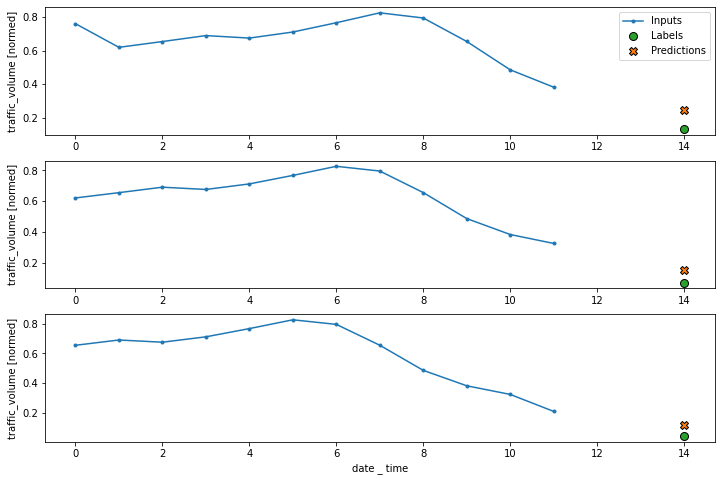

In [49]:
wide_window_12_1_3.plot(model1)#plotting the model

### Loss plot

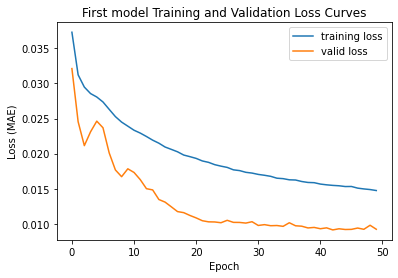

In [50]:
plt.plot(history1.history['loss'], label='training loss')#plotting training loss 
plt.plot(history1.history['val_loss'], label = 'valid loss')#plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.title('First model Training and Validation Loss Curves')
plt.show()

### Model2: Adding layers

In [77]:
model2=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 240 units
    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 240 units
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer
    
    tf.keras.layers.Dense(64, activation='relu'),#dense layer with 64 units with relu as activation
    tf.keras.layers.Dense(32, activation='relu'),#dense layer with 32 units with relu as activation
    tf.keras.layers.Dense(1),#dense layer with 1 unit
    tf.keras.layers.Reshape([1, -1]),#reshaping at the last #note:this layer is important for window plotting
])

### Compiling and evaluating the model

In [78]:
history2 = compile_and_fit(model2, wide_window_12_1_3)#compile and fitting using the defined function

performance_validation['Model2'] = model2.evaluate(wide_window_12_1_3.val)#evaluating validation data
performance_test['Model2'] = model2.evaluate(wide_window_12_1_3.test, verbose=0)#evaluating test data

Epoch 1/50
955/955 [==============================] - 23s 17ms/step - loss: 0.0383 - mean_absolute_error: 0.1464 - val_loss: 0.0248 - val_mean_absolute_error: 0.1169
Epoch 2/50
955/955 [==============================] - 14s 14ms/step - loss: 0.0341 - mean_absolute_error: 0.1359 - val_loss: 0.0329 - val_mean_absolute_error: 0.1347
Epoch 3/50
955/955 [==============================] - 15s 16ms/step - loss: 0.0343 - mean_absolute_error: 0.1361 - val_loss: 0.0379 - val_mean_absolute_error: 0.1457
Epoch 4/50
955/955 [==============================] - 14s 14ms/step - loss: 0.0354 - mean_absolute_error: 0.1392 - val_loss: 0.0308 - val_mean_absolute_error: 0.1348
Epoch 5/50
955/955 [==============================] - 14s 15ms/step - loss: 0.0338 - mean_absolute_error: 0.1352 - val_loss: 0.0329 - val_mean_absolute_error: 0.1424
Epoch 6/50
955/955 [==============================] - 15s 16ms/step - loss: 0.0341 - mean_absolute_error: 0.1359 - val_loss: 0.0393 - val_mean_absolute_error: 0.1568
Epoc

### Plot

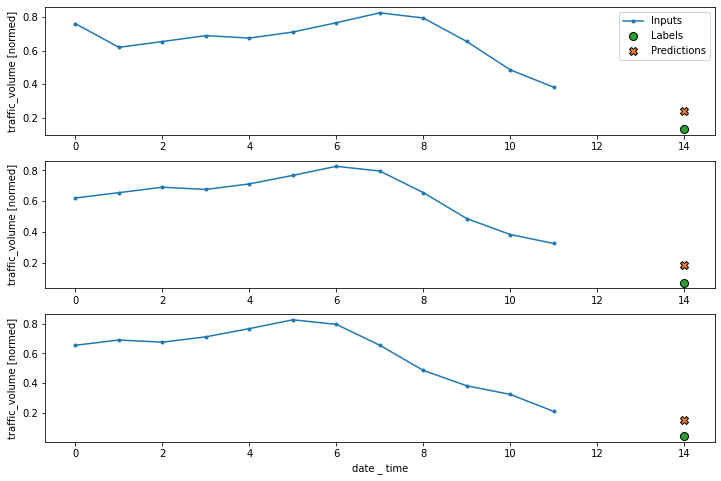

In [53]:
wide_window_12_1_3.plot(model2)#plotting the model

### Loss plot 

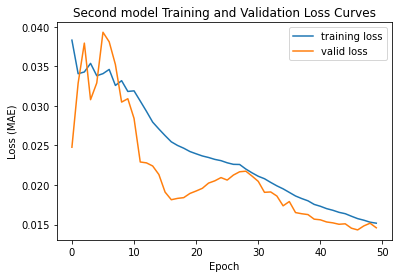

In [97]:
plt.plot(history2.history['loss'], label='training loss')#plotting training loss 
plt.plot(history2.history['val_loss'], label = 'valid loss')#plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.title('Second model Training and Validation Loss Curves')
plt.show()

### Model3: Batchnormalization

In [79]:
model3=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 240 units
    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 240 units
    tf.keras.layers.BatchNormalization(),#batchnormalization layer
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.BatchNormalization(),#batchnormalization layer
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.BatchNormalization(),#batchnormalization layer
    tf.keras.layers.Dropout(0.2),#dropout layer
    
    tf.keras.layers.Dense(64, activation='relu'),#dense layer with 64 units with relu as activation
    tf.keras.layers.Dense(32, activation='relu'),#dense layer with 32 units with relu as activation
    tf.keras.layers.Dense(1),#dense layer with 1 unit
    tf.keras.layers.Reshape([1, -1]),#reshaping at the last #note:this layer is important for window plotting
])

### Compiling and evaluating the model

In [80]:
history3 = compile_and_fit(model3, wide_window_12_1_3)#compile and fitting using the defined function

performance_validation['Model3'] = model3.evaluate(wide_window_12_1_3.val)#evaluating validation data
performance_test['Model3'] = model3.evaluate(wide_window_12_1_3.test, verbose=0)#evaluating test data

Epoch 1/50
955/955 [==============================] - 33s 24ms/step - loss: 0.0490 - mean_absolute_error: 0.1653 - val_loss: 0.0229 - val_mean_absolute_error: 0.1092
Epoch 2/50
955/955 [==============================] - 20s 21ms/step - loss: 0.0335 - mean_absolute_error: 0.1349 - val_loss: 0.0195 - val_mean_absolute_error: 0.1049
Epoch 3/50
955/955 [==============================] - 22s 23ms/step - loss: 0.0268 - mean_absolute_error: 0.1165 - val_loss: 0.0230 - val_mean_absolute_error: 0.1199
Epoch 4/50
955/955 [==============================] - 21s 22ms/step - loss: 0.0253 - mean_absolute_error: 0.1118 - val_loss: 0.0167 - val_mean_absolute_error: 0.0952
Epoch 5/50
955/955 [==============================] - 20s 21ms/step - loss: 0.0229 - mean_absolute_error: 0.1056 - val_loss: 0.0180 - val_mean_absolute_error: 0.0991
Epoch 6/50
955/955 [==============================] - 21s 22ms/step - loss: 0.0207 - mean_absolute_error: 0.0987 - val_loss: 0.0199 - val_mean_absolute_error: 0.1066
Epoc

### Plot 

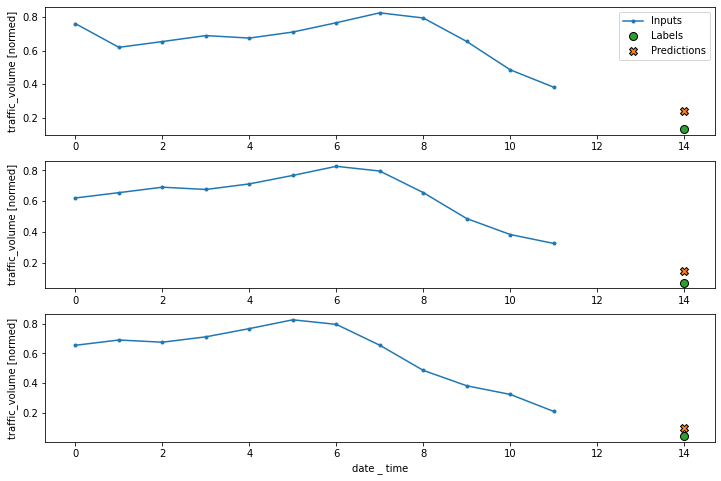

In [81]:
wide_window_12_1_3.plot(model3)#plotting the model

### Loss plot

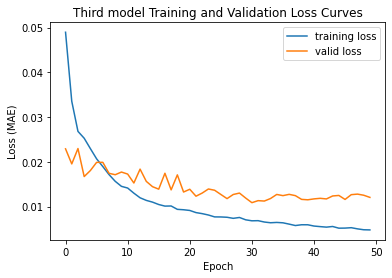

In [98]:
plt.plot(history3.history['loss'], label='training loss')#plotting training loss 
plt.plot(history3.history['val_loss'], label = 'valid loss')#plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.title('Third model Training and Validation Loss Curves')
plt.show()

Importing these packagese to make the model with less content

In [50]:
from tensorflow import keras#importing keras from tensorflow
from keras import layers#importing layers from keras

### Model4: Best model

In [102]:
model4=tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(layers.LSTM(512, return_sequences=True,stateful=False)),#Bidirectional LSTM layer with 128 units and stateful as False
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    
    tf.keras.layers.Dense(units=64, activation='relu'),#dense layer with 64 units with relu as activation
    tf.keras.layers.Dense(32, activation='relu'),#dense layer with 32 units with relu as activation
    tf.keras.layers.Dense(1),#dense layer with 1 unit
    tf.keras.layers.Reshape([1, -1]),#reshaping at the last #note:this layer is important for window plotting
])


### Compiling and evaluating the model

In [103]:
history4 = compile_and_fit(model4, wide_window_12_1_3)#compile and fitting using the defined function

performance_validation['Model4'] = model4.evaluate(wide_window_12_1_3.val)#evaluating validation data
performance_test['Model4'] = model4.evaluate(wide_window_12_1_3.test, verbose=0)#evaluating test data

Epoch 1/50
955/955 [==============================] - 23s 17ms/step - loss: 0.0275 - mean_absolute_error: 0.1187 - val_loss: 0.0211 - val_mean_absolute_error: 0.1016
Epoch 2/50
955/955 [==============================] - 14s 15ms/step - loss: 0.0231 - mean_absolute_error: 0.1079 - val_loss: 0.0197 - val_mean_absolute_error: 0.0963
Epoch 3/50
955/955 [==============================] - 15s 16ms/step - loss: 0.0214 - mean_absolute_error: 0.1021 - val_loss: 0.0170 - val_mean_absolute_error: 0.0891
Epoch 4/50
955/955 [==============================] - 14s 15ms/step - loss: 0.0187 - mean_absolute_error: 0.0930 - val_loss: 0.0148 - val_mean_absolute_error: 0.0795
Epoch 5/50
955/955 [==============================] - 15s 16ms/step - loss: 0.0161 - mean_absolute_error: 0.0843 - val_loss: 0.0136 - val_mean_absolute_error: 0.0754
Epoch 6/50
955/955 [==============================] - 14s 15ms/step - loss: 0.0137 - mean_absolute_error: 0.0762 - val_loss: 0.0142 - val_mean_absolute_error: 0.0745
Epoc

### Plot

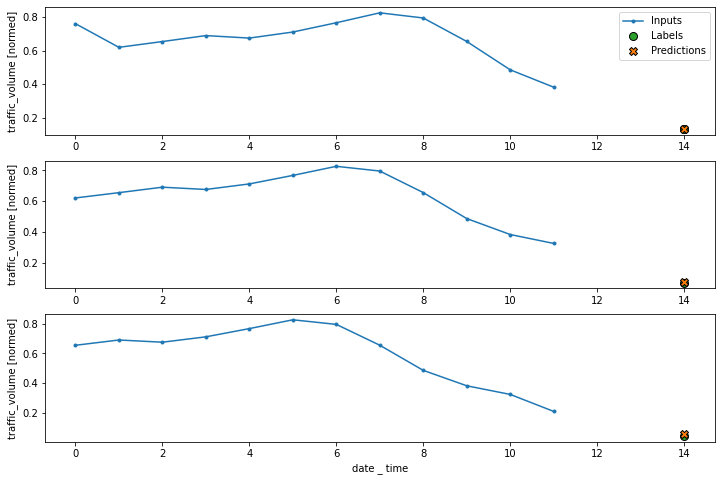

In [104]:
wide_window_12_1_3.plot(model4)#plotting the model

### Loss plot

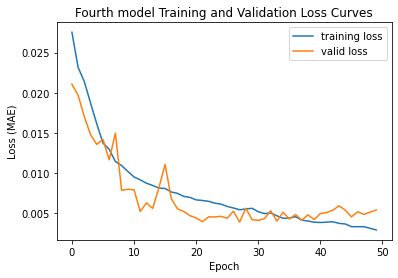

In [105]:
plt.plot(history4.history['loss'], label='training loss') #plotting training loss
plt.plot(history4.history['val_loss'], label = 'valid loss')#plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.title('Fourth model Training and Validation Loss Curves')
plt.show()

### Model5: Additional bidirectional layers

In [51]:
model5=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 240 units
    tf.keras.layers.Bidirectional(layers.LSTM(240, return_sequences=True)),#Bidirectional LSTM layer with 240 units
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Bidirectional(layers.LSTM(128, return_sequences=True)),#Bidrectional LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Bidirectional(layers.LSTM(128, return_sequences=True)),#Bidirectional LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.Flatten(),#flatten layer
    tf.keras.layers.Dense(128, activation='relu'),#dense layer with 128 units with relu as activation
    tf.keras.layers.BatchNormalization(),#batchnormalization layer

    tf.keras.layers.Dense(64, activation='relu'),#dense layer with 64 units with relu as activation
    tf.keras.layers.BatchNormalization(),#batchnormalization layer

    tf.keras.layers.Dense(32, activation='relu'),#dense layer with 32 units with relu as activation
    tf.keras.layers.BatchNormalization(),#batchnormalization layer

    tf.keras.layers.Dense(1),#dense layer with 1 unit
    tf.keras.layers.Reshape([1, -1]),#reshaping at the last #note:this layer is important for window plotting
])

### Compiling and evaluating the model

In [52]:
history5 = compile_and_fit(model5, wide_window_12_1_3)#compile and fitting using the defined function

performance_validation['Model5'] = model5.evaluate(wide_window_12_1_3.val)#evaluating validation data
performance_test['Model5'] = model5.evaluate(wide_window_12_1_3.test, verbose=0)#evaluating test data

Epoch 1/50
955/955 [==============================] - 54s 32ms/step - loss: 0.1228 - mean_absolute_error: 0.2194 - val_loss: 0.0356 - val_mean_absolute_error: 0.1371
Epoch 2/50
955/955 [==============================] - 28s 29ms/step - loss: 0.0317 - mean_absolute_error: 0.1326 - val_loss: 0.0211 - val_mean_absolute_error: 0.1040
Epoch 3/50
955/955 [==============================] - 27s 28ms/step - loss: 0.0272 - mean_absolute_error: 0.1220 - val_loss: 0.0239 - val_mean_absolute_error: 0.1167
Epoch 4/50
955/955 [==============================] - 27s 28ms/step - loss: 0.0254 - mean_absolute_error: 0.1170 - val_loss: 0.0219 - val_mean_absolute_error: 0.1042
Epoch 5/50
955/955 [==============================] - 27s 29ms/step - loss: 0.0293 - mean_absolute_error: 0.1276 - val_loss: 0.0427 - val_mean_absolute_error: 0.1603
Epoch 6/50
955/955 [==============================] - 30s 32ms/step - loss: 0.0268 - mean_absolute_error: 0.1221 - val_loss: 0.0297 - val_mean_absolute_error: 0.1366
Epoc

### Plot

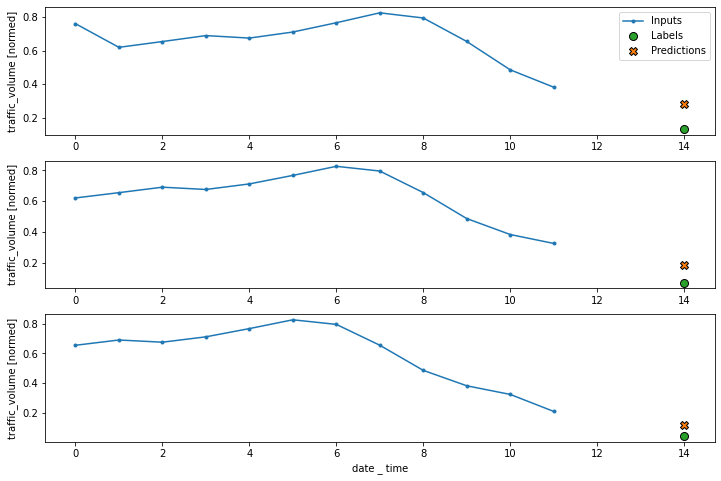

In [53]:
wide_window_12_1_3.plot(model5)#plotting the model

### Loss plot

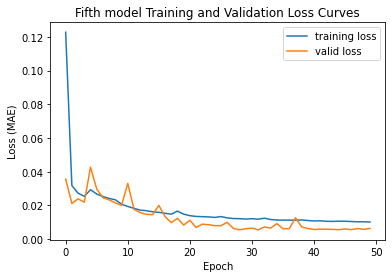

In [100]:
plt.plot(history5.history['loss'], label='training loss')#plotting training loss
plt.plot(history5.history['val_loss'], label = 'valid loss')#plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.title('Fifth model Training and Validation Loss Curves')
plt.show()

### Model6: RNN and CNN model 

In [55]:
model6=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(256, kernel_size=3, padding='same',activation='relu'),#Convolutional layer with 256 units with activation as relu and kernel size of three with padding
    tf.keras.layers.Conv1D(128, kernel_size=3, padding='same',activation='relu'),#Convolutional layer with 128 units with activation as relu and kernel size of three with padding
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.LSTM(240, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer

    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.LSTM(128, return_sequences=True),#LSTM layer with 128 units
    tf.keras.layers.Dropout(0.2),#dropout layer
    
    tf.keras.layers.Dense(64, activation='relu'),#dense layer with 64 units with relu as activation
    tf.keras.layers.Dense(32, activation='relu'),#dense layer with 32 units with relu as activation
    tf.keras.layers.Dense(1),#dense layer with 1 unit
    tf.keras.layers.Reshape([1, -1]),#reshaping at the last #note:this layer is important for window plotting
])

### Compiling and evaluating the model

In [56]:
history6 = compile_and_fit(model6, wide_window_12_1_3)#compile and fitting using the defined function

performance_validation['Model6'] = model6.evaluate(wide_window_12_1_3.val)#evaluating validation data
performance_test['Model6'] = model6.evaluate(wide_window_12_1_3.test, verbose=0)#evaluating test data

Epoch 1/50
955/955 [==============================] - 26s 17ms/step - loss: 0.0381 - mean_absolute_error: 0.1447 - val_loss: 0.0199 - val_mean_absolute_error: 0.1001
Epoch 2/50
955/955 [==============================] - 16s 17ms/step - loss: 0.0317 - mean_absolute_error: 0.1301 - val_loss: 0.0225 - val_mean_absolute_error: 0.1076
Epoch 3/50
955/955 [==============================] - 16s 17ms/step - loss: 0.0306 - mean_absolute_error: 0.1266 - val_loss: 0.0187 - val_mean_absolute_error: 0.0928
Epoch 4/50
955/955 [==============================] - 16s 17ms/step - loss: 0.0289 - mean_absolute_error: 0.1221 - val_loss: 0.0175 - val_mean_absolute_error: 0.0885
Epoch 5/50
955/955 [==============================] - 15s 16ms/step - loss: 0.0275 - mean_absolute_error: 0.1176 - val_loss: 0.0179 - val_mean_absolute_error: 0.0912
Epoch 6/50
955/955 [==============================] - 15s 16ms/step - loss: 0.0265 - mean_absolute_error: 0.1139 - val_loss: 0.0176 - val_mean_absolute_error: 0.0906
Epoc

### Plot

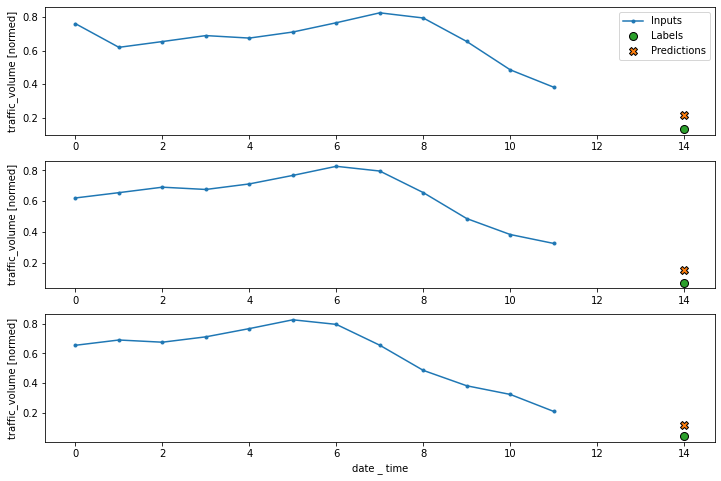

In [57]:
wide_window_12_1_3.plot(model6)#plotting the model

### Loss plot 

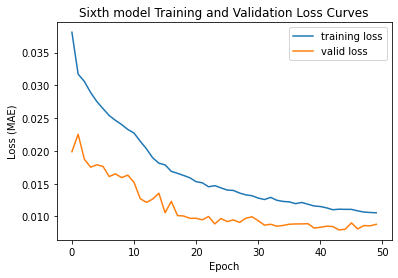

In [101]:
plt.plot(history6.history['loss'], label='training loss')#plotting training loss 
plt.plot(history6.history['val_loss'], label = 'valid loss')#plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.title('Sixth model Training and Validation Loss Curves')
plt.show()

## Denormalizing the data 

For the predictions to have the correct values we need to denormalize the predicted output

In [106]:
target_column = traffic_data['traffic_volume']#the target column
minimum_value = target_column.min()#minimum value of the target column
maximum_value = target_column.max()#maximum value of the target column
print(minimum_value)# printing minimum value of the target column
print(maximum_value)#printing maximum value of the target column

0
7280


In [90]:
results=model3.predict(wide_window_12_1_3.test)#predicting the models with the test #note: change the model names according to which we want to predict
results = results.squeeze()#squeezing the result to be in the 2D 

print(len(results))#printing the length


predict_DF = pd.DataFrame(results)#getting dataframe from the results variable
print(predict_DF)#printing the obtained data frame

index = np.array(test_traffic_data.index)#indexing the test data
index = np.delete(index, slice(0,14), axis=0)#slicing to be in the same size
predict_DF['id'] = index#setting index to id as said
predict_DF = predict_DF.rename({0: 'prediction'}, axis=1)#renaming the column name to prediction
predict_DF = predict_DF.reindex(columns=['id','prediction'])#setting the column names as told
predict_DF['prediction'] = predict_DF['prediction'].astype(float)#converting the prediction column to float
predict_DF.head()#view the first five of the dataframe obtained
preds = predict_DF.prediction.values.tolist()#converting it to the list

new_preds = []#creating an empty list
for z in range(0, len(preds)):
  ans = preds[z] * (maximum_value - minimum_value)  + minimum_value#denormalizing the predictions using minmax
  new_preds.append(ans)#appending the answer to the list created

predict_DF['prediction'] = new_preds#printing the prediction 
predict_DF['prediction'] = predict_DF['prediction'].astype(float)#converting it to the float
predict_DF.to_csv('predict.csv', index=False)#converting into a csv file

156/156 [==============================] - 3s 9ms/step
4986
            0         1         2         3         4         5         6   \
0     0.670632  0.671134  0.670498  0.673804  0.676308  0.686477  0.695471   
1     0.729314  0.736392  0.728135  0.723779  0.741704  0.761674  0.758090   
2     0.758993  0.752702  0.735133  0.763169  0.781275  0.782948  0.783484   
3     0.781644  0.788325  0.792696  0.824922  0.836949  0.834369  0.832710   
4     0.698277  0.683607  0.718250  0.735269  0.744650  0.750177  0.767150   
...        ...       ...       ...       ...       ...       ...       ...   
4981  0.491282  0.479950  0.486079  0.487116  0.487625  0.486668  0.490105   
4982  0.453101  0.451219  0.459200  0.466846  0.473061  0.473621  0.476307   
4983  0.430920  0.440234  0.444476  0.445265  0.445570  0.446991  0.448351   
4984  0.374164  0.377557  0.354562  0.345416  0.341347  0.342011  0.344038   
4985  0.292942  0.266980  0.255438  0.231736  0.225136  0.228939  0.234691   

   

In [91]:
len(results)#printing length of the results

4986

In [92]:
print(new_preds)#printing the predictions

[4882.200560569763, 5309.402661323547, 5525.4714250564575, 5690.366487503052, 5083.460006713867, 3981.903920173645, 3392.3907613754272, 3234.5004987716675, 3061.4589881896973, 2541.281328201294, 1662.6284909248352, 842.7554619312286, 660.5937284231186, 468.36424946784973, 472.8055477142334, 809.3674564361572, 2296.16779088974, 4672.128162384033, 5387.342829704285, 4424.798369407654, 4410.933265686035, 4335.722031593323, 4731.77722454071, 4751.506781578064, 4925.086355209351, 5177.248735427856, 5319.563808441162, 5412.299842834473, 4586.916332244873, 3963.637547492981, 3388.1270456314087, 3155.610475540161, 3118.742308616638, 2862.1461153030396, 1760.953872203827, 1105.3990066051483, 727.797532081604, 511.75610542297363, 390.1626431941986, 721.8630003929138, 2191.7156505584717, 5547.085070610046, 5796.97413444519, 4619.789381027222, 4359.00671005249, 4377.0982122421265, 4586.130499839783, 4775.016231536865, 4906.955366134644, 5188.471689224243, 5317.221064567566, 5408.423619270325, 4848

In [76]:
from google.colab import files#importing package to download
files.download('predict.csv')#downloading the csv

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [93]:
print(predict_DF)#printing the final output

         id   prediction
0     35589  4882.200561
1     35590  5309.402661
2     35591  5525.471425
3     35592  5690.366488
4     35593  5083.460007
...     ...          ...
4981  40570  3576.534162
4982  40571  3298.572092
4983  40572  3137.094598
4984  40573  2723.916850
4985  40574  2132.614198

[4986 rows x 2 columns]


## MAE 

To predict the MAE by myself I tried to create a function with the MAE formula

In [72]:
def mean_absolute_error(target, predicted):#MAE function
    number = 4986#length of the results
    sum = 0 #initializing sum to be 0
    for i in range(number):
        sum += abs(target - predicted)#from the MAE formula
  
    error = sum/number#getting the average of the MAE

    return error#returning the MAE

In [94]:
test_data=data_viz[35589:]#taking the test set from the coppied data at the beggining
test_data.drop(['holiday',    'temp',  'rain_1h',  'snow_1h',  'clouds_all'  ,'weather_main','weather_description'],axis =1,inplace=True )#dropping unwanted variables
test_data.reset_index(inplace=True)#resetting index to be true
test_data.columns = test_data.columns.str.replace('index', 'id')#replacing index with id
pred_values = predict_DF.merge(test_data, on='id',how='left')#moving on left

print(pred_values)#printing the combined predictions

         id   prediction  traffic_volume
0     35589  4882.200561            4166
1     35590  5309.402661            4671
2     35591  5525.471425            5260
3     35592  5690.366488            6420
4     35593  5083.460007            5874
...     ...          ...             ...
4981  40570  3576.534162            3543
4982  40571  3298.572092            2781
4983  40572  3137.094598            2159
4984  40573  2723.916850            1450
4985  40574  2132.614198             954

[4986 rows x 3 columns]


In [95]:
data_col = pred_values['traffic_volume']#target variable
original = data_col.to_frame().traffic_volume.to_list()#converting target to list
preds_col = pred_values['prediction']#predicted answers
answers = preds_col.to_frame().prediction.to_list()#converting it to the list

mae = []#empty list
for z in range(0, len(pred_values)):
  ans = mean_absolute_error(original[z],answers[z])#calling the MAE function
  mae.append(ans)#appending to the list

In [96]:
Sum = sum(mae)#adding all the answers in the list
val = Sum/ 4986#getting the MAE
print(val)#visualising the MAE

590.7956796700678


The result was not the same as in Kaggle but it was pretty close to the original MAE.